# Unit 4 Unsupervised Learning Capstone Project

For this project you'll dig into a large amount of text and apply most of what you've covered in this unit and in the course so far.

First, pick a set of texts. This can be either a series of novels, chapters, or articles. Anything you'd like. It just has to have multiple entries of varying characteristics. At least 100 should be good. There should also be at least 10 different authors, but try to keep the texts related (either all on the same topic of from the same branch of literature - something to make classification a bit more difficult than obviously different subjects).

This capstone can be an extension of your NLP challenge if you wish to use the same corpus. If you found problems with that data set that limited your analysis, however, it may be worth using what you learned to choose a new corpus. Reserve 25% of your corpus as a test set.

The first technique is to create a series of clusters. Try several techniques and pick the one you think best represents your data. Make sure there is a narrative and reasoning around why you have chosen the given clusters. Are authors consistently grouped into the same cluster?

Next, perform some unsupervised feature generation and selection using the techniques covered in this unit and elsewhere in the course. Using those features then build models to attempt to classify your texts by author. Try different permutations of unsupervised and supervised techniques to see which combinations have the best performance.

Lastly return to your holdout group. Does your clustering on those members perform as you'd expect? Have your clusters remained stable or changed dramatically? What about your model? Is it's performance consistent?

If there is a divergence in the relative stability of your model and your clusters, delve into why.

Your end result should be a write up of how clustering and modeling compare for classifying your texts. What are the advantages of each? Why would you want to use one over the other? Approximately 3-5 pages is a good length for your write up, and remember to include visuals to help tell your story!

Dataset: https://www.kaggle.com/snap/amazon-fine-food-reviews 

In [1]:
#Basic imports 
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re

#NLP imports 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
nlp = spacy.load('en')
from sklearn.feature_extraction.text import TfidfVectorizer

#Dimension Reduction 
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import Normalizer

#Clustering 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

#Clustering Evaluation 
from scipy.spatial.distance import cdist
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

#Model Imports  
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

#Model Optimization 
from sklearn import ensemble
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.metrics import confusion_matrix

#Time
import time 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
df = pd.read_csv('https://www.dropbox.com/s/d4ye48a67tth2ae/Reviews.csv?dl=1')

In [3]:
#drop uneccessary columns 
df.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Time', 'Summary'],axis=1,inplace=True)
df.head()

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 2 columns):
Score    568454 non-null int64
Text     568454 non-null object
dtypes: int64(1), object(1)
memory usage: 8.7+ MB


In [5]:
df.isnull().sum()

Score    0
Text     0
dtype: int64

In [0]:
# Remove duplicate reviews  
df.drop_duplicates(subset=['Score','Text'],keep='first',inplace=True)  

In [7]:
df.Score.value_counts()

5    250745
4     56074
1     36280
3     29772
2     20804
Name: Score, dtype: int64

In [0]:
# Utility function to clean text.
def text_cleaner(text):
    
    # Visual inspection shows spaCy does not recognize the double dash '--'.
    
    text = re.sub(r'--',' ',text)
    
    # Removes hyperlinks 
    text = re.sub(r'<a\s+href=(?:"([^"]+)"|\'([^\']+)\').*?>(.*?)</a>',' ', text)
    
    # Get rid of extra whitespace.
    text = ' '.join(text.split())
    
    # Lowercase text
    text = text.lower()
    
    return text

In [0]:
df['Clean'] = df['Text'].apply(lambda x: text_cleaner(x))

In [0]:
# Create Utility function to lemmatize our text reviews limiting variations on same words
lemma = spacy.lang.en.English()

def lemma_text(text):
    tokens = lemma(text) 
    return([token.lemma_ for token in tokens if not token.is_punct and not token.is_stop])

df['lemma_text'] = df.Clean.apply(lemma_text)

In [11]:
df.head()

,Score,Text,Clean,lemma_text
0,5,I have bought several of the Vitality canned d...,i have bought several of the vitality canned d...,"[buy, vitality, can, dog, food, product, find,..."
1,1,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled as jumbo salted peanut...,"[product, arrive, label, jumbo, salt, peanut, ..."
2,4,This is a confection that has been around a fe...,this is a confection that has been around a fe...,"[confection, century, light, pillowy, citrus, ..."
3,2,If you are looking for the secret ingredient i...,if you are looking for the secret ingredient i...,"[look, secret, ingredient, robitussin, believe..."
4,5,Great taffy at a great price. There was a wid...,great taffy at a great price. there was a wide...,"[great, taffy, great, price, wide, assortment,..."


## Feature Generation

In [0]:
# Identifying variables
X = df['Clean']
y = df['Score']

# Splitting into train and test sets, reserve 40% for test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=0)

In [0]:
# Total word count 
feature_df = pd.DataFrame()
feature_df['word_count'] = [len(x.split()) for x in X_train.tolist()]

# Count of punctuations 
feature_df['exclamation_marks'] = X_train.str.findall(r'[!]').str.len()
feature_df['periods'] = X_train.str.findall(r'[.]').str.len()
feature_df['question_marks'] = X_train.str.findall(r'[?]').str.len()
feature_df['Text'] = X_train
feature_df['Score'] = y_train

In [14]:
# Let's check our new features
feature_df.head()

,word_count,exclamation_marks,periods,question_marks,Text,Score
0,64,0.0,3.0,0.0,i have bought several of the vitality canned d...,5.0
1,204,0.0,5.0,0.0,product arrived labeled as jumbo salted peanut...,1.0
2,175,0.0,9.0,0.0,this is a confection that has been around a fe...,4.0
3,86,0.0,3.0,0.0,if you are looking for the secret ingredient i...,2.0
4,60,0.0,4.0,0.0,great taffy at a great price. there was a wide...,5.0


In [15]:
# Initialize vectorizer 
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True, #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                             tokenizer=lemma_text)


# Applying the vectorizer
X_tfidf = vectorizer.fit_transform(X)
print("Number of features: %d" % X_tfidf.get_shape()[1])

# Splitting into train and test sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.40, random_state=0)

Number of features: 70088


## Dimensionality Reduction

In [16]:
#Our SVD data reducer.  We are going to reduce the feature space from upwards of 70k to 1500 
#Ideally we would try to capture no less than 90% variance in the dataset, but due to computational limitations, we'll have to sacrifice variance
svd= TruncatedSVD(800)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()

print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 54.67872292509812


In [17]:
tfidf_df = pd.DataFrame(data=X_train_lsa)
tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,0.166350,-0.021195,-0.010114,-0.094244,-0.045712,0.061675,-0.114701,0.104000,-0.008437,-0.174588,...,-0.007047,0.015754,-0.012458,-0.008289,0.006294,0.008888,-0.010325,-0.005700,0.015919,0.007431
1,0.231892,-0.038743,-0.009493,-0.124592,-0.067768,0.071977,-0.018226,0.117971,-0.027938,-0.030612,...,0.035726,0.011500,-0.010286,-0.040892,-0.032055,-0.007342,-0.007115,-0.034871,0.035192,0.101014
2,0.390152,-0.177157,-0.059470,0.116885,-0.036992,0.047264,-0.221312,-0.113622,0.093568,0.011947,...,0.006086,-0.006935,0.003458,0.006959,-0.007903,-0.007318,-0.007191,-0.017109,0.021170,0.015698
3,0.411509,-0.043032,0.005762,-0.106735,-0.013786,-0.065681,-0.128256,-0.050892,-0.102618,-0.083316,...,-0.048340,0.020057,0.048650,-0.006727,-0.007601,0.001705,-0.010261,0.019301,-0.011685,0.006382
4,0.224481,-0.066947,-0.016732,-0.060596,-0.084058,0.115606,-0.018186,-0.007607,-0.097803,0.023202,...,0.025245,0.051943,0.037522,0.069100,0.010602,0.068238,-0.026551,-0.028691,-0.008070,0.013510


In [18]:
new_df = pd.concat([tfidf_df, feature_df], ignore_index=False, axis=1)
new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,796,797,798,799,word_count,exclamation_marks,periods,question_marks,Text,Score
0,0.166350,-0.021195,-0.010114,-0.094244,-0.045712,0.061675,-0.114701,0.104000,-0.008437,-0.174588,...,-0.010325,-0.005700,0.015919,0.007431,64,0.0,3.0,0.0,i have bought several of the vitality canned d...,5.0
1,0.231892,-0.038743,-0.009493,-0.124592,-0.067768,0.071977,-0.018226,0.117971,-0.027938,-0.030612,...,-0.007115,-0.034871,0.035192,0.101014,204,0.0,5.0,0.0,product arrived labeled as jumbo salted peanut...,1.0
2,0.390152,-0.177157,-0.059470,0.116885,-0.036992,0.047264,-0.221312,-0.113622,0.093568,0.011947,...,-0.007191,-0.017109,0.021170,0.015698,175,0.0,9.0,0.0,this is a confection that has been around a fe...,4.0
3,0.411509,-0.043032,0.005762,-0.106735,-0.013786,-0.065681,-0.128256,-0.050892,-0.102618,-0.083316,...,-0.010261,0.019301,-0.011685,0.006382,86,0.0,3.0,0.0,if you are looking for the secret ingredient i...,2.0
4,0.224481,-0.066947,-0.016732,-0.060596,-0.084058,0.115606,-0.018186,-0.007607,-0.097803,0.023202,...,-0.026551,-0.028691,-0.008070,0.013510,60,0.0,4.0,0.0,great taffy at a great price. there was a wide...,5.0


In [0]:
new_df = new_df.replace([np.inf, -np.inf], np.nan).dropna()

## Clustering

In [0]:
# Declare clustering variables  
features = new_df.drop(['Score','Text'], axis=1)
predict = new_df['Score']

In [21]:
from sklearn.preprocessing import MinMaxScaler

# Clustering algorithms need normalization
scalar = MinMaxScaler()

scaled = scalar.fit_transform(features)
scaled_df = pd.DataFrame(scaled)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### KMeans

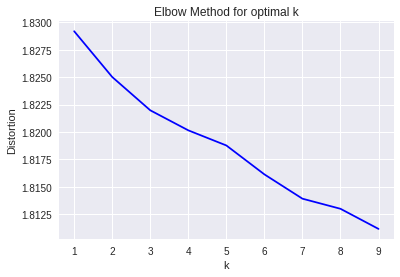

In [22]:
# Let's see what the elbow curve tells us would be the optimal K value 
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(scaled)
    kmeanModel.fit(scaled)
    distortions.append(sum(np.min(cdist(scaled, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / scaled.shape[0])
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method for optimal k')
plt.show()

Looks like 2 clusters are best per the elbow method, perhaps due to sentiment in the reviews (either positive or negative)

In [24]:
# Declare and fit clustering model using K of 5 for our 5 scores
kmeans = KMeans(n_clusters=5, random_state=0)
y_pred = kmeans.fit_predict(scaled)

pd.crosstab(predict, y_pred)

col_0,0,1,2,3,4
Score,,,,,
1.0,254,5136,558,1395,3064
2.0,149,3001,351,807,1748
3.0,197,4189,470,1263,2537
4.0,399,8132,882,2186,4714
5.0,1706,35064,3678,9321,20703


In [25]:
print('Adjusted Rand Score: {:0.5}'.format(adjusted_rand_score(predict, y_pred)))
print('Silhouette Score: {:0.5}'.format(silhouette_score(scaled, y_pred, metric='euclidean')))

Adjusted Rand Score: 0.0021326
Silhouette Score: -0.019539


### Minibatch KMeans

In [26]:
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='k-means++',
    n_clusters=5,
    batch_size=200)
minibatchkmeans.fit(scaled)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(scaled)

# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict, predict_mini))

Comparing k-means and mini batch k-means solutions:
col_0     0      1      2      3     4
Score                                 
1.0     155   2526   4108   2158  1460
2.0      93   1436   2405   1282   840
3.0     126   2100   3395   1731  1304
4.0     277   3884   6512   3384  2256
5.0    1082  16969  28380  14372  9669


In [27]:
print('Adjusted Rand Score: {:0.5}'.format(adjusted_rand_score(predict, predict_mini)))
print('Silhouette Score: {:0.5}'.format(silhouette_score(scaled, predict_mini, metric='euclidean')))

Adjusted Rand Score: 0.0017331
Silhouette Score: -0.019541


From what we can see with these two clustering methods scores being close to zero, it appears that most of the observations lie between two clusters. 

## Modeling: Training Set

### Logistic Regression: Training Set

In [28]:
lr = LogisticRegression(class_weight = 'balanced')
train = lr.fit(scaled, predict)
lr_scores = cross_val_score(lr, scaled, predict, cv=5)

print('\nCross Validation Training Scores:{:.5f}(+/- {:.3f})'.format(lr_scores.mean(), lr_scores.std()*2))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed


Cross Validation Training Scores:0.58388(+/- 0.006)


In [29]:
from sklearn.metrics import classification_report

sk_lr_report = classification_report(
    digits=6,
    y_true=predict, 
    y_pred=lr.predict(scaled))
print('\nClasification report:\n', sk_lr_report)

sk_lr_report2 = confusion_matrix(y_true=predict, y_pred=lr.predict(scaled))

print('\nConfusion Matrix:\n',sk_lr_report2)


Clasification report:
               precision    recall  f1-score   support

         1.0   0.227677  0.056597  0.090657     10407
         2.0   0.136297  0.076948  0.098364      6056
         3.0   0.184326  0.072551  0.104120      8656
         4.0   0.256564  0.034145  0.060268     16313
         5.0   0.650638  0.926212  0.764345     70472

   micro avg   0.603303  0.603303  0.603303    111904
   macro avg   0.291100  0.233290  0.223551    111904
weighted avg   0.489951  0.603303  0.511943    111904


Confusion Matrix:
 [[  589   408   423   238  8749]
 [  207   466   241   155  4987]
 [  282   355   628   241  7150]
 [  392   606   596   557 14162]
 [ 1117  1584  1519   980 65272]]


### Random Forest: Training Set

In [30]:
rfc = RandomForestClassifier(class_weight = 'balanced_subsample')
train = rfc.fit(scaled, predict)
rfc_scores = cross_val_score(rfc, scaled, predict, cv=5)

print('\nCross Validation Training Scores:{:.5f}(+/- {:.3f})'.format(rfc_scores.mean(), rfc_scores.std()*2))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Cross Validation Training Scores:0.60162(+/- 0.001)


In [31]:
sk_rfc_report = classification_report(
    digits=6,
    y_true=predict, 
    y_pred=rfc.predict(scaled))
print('\nClasification report:\n', sk_rfc_report)

sk_rfc_report2 = confusion_matrix(y_true=predict, y_pred=rfc.predict(scaled))

print('\nConfusion Matrix:\n',sk_rfc_report2)


Clasification report:
               precision    recall  f1-score   support

         1.0   0.998399  0.958874  0.978237     10407
         2.0   0.999309  0.955416  0.976870      6056
         3.0   0.998441  0.961876  0.979818      8656
         4.0   0.997658  0.966223  0.981689     16313
         5.0   0.978633  0.999588  0.989000     70472

   micro avg   0.985631  0.985631  0.985631    111904
   macro avg   0.994488  0.968396  0.981123    111904
weighted avg   0.985896  0.985631  0.985567    111904


Confusion Matrix:
 [[ 9979     0     2     4   422]
 [    8  5786     0     4   258]
 [    2     1  8326     7   320]
 [    5     2     6 15762   538]
 [    1     1     5    22 70443]]


## Modeling: Test Set

We'll need to process the test group as we did the training set above.

In [0]:
# Total word count 
feature_df_test = pd.DataFrame()
feature_df_test['word_count'] = [len(x.split()) for x in X_test.tolist()]

# Count of punctuations 
feature_df_test['exclamation_marks'] = X_test.str.findall(r'[!]').str.len()
feature_df_test['periods'] = X_test.str.findall(r'[.]').str.len()
feature_df_test['question_marks'] = X_test.str.findall(r'[?]').str.len()
feature_df_test['Text'] = X_test
feature_df_test['Score'] = y_test

In [33]:
#Our SVD data reducer.  We are going to reduce the feature space to 800 again for test.
svd= TruncatedSVD(800)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_test_lsa = lsa.fit_transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()

print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 54.881326752600955


In [34]:
tfidf_df_test = pd.DataFrame(data=X_test_lsa)
tfidf_df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,0.181176,-0.059937,0.000115,-0.107312,-0.099659,-0.035958,0.045923,0.106981,0.011003,-0.020440,...,0.010516,0.008997,0.017296,0.036113,0.010994,-0.009497,0.039784,0.011166,0.001259,-0.017866
1,0.212698,-0.148848,0.003270,0.212605,-0.146578,-0.024711,-0.039786,-0.046825,-0.051085,-0.057712,...,0.001517,0.001584,-0.010008,-0.011911,-0.004064,-0.002245,0.003945,0.004081,-0.001137,0.002342
2,0.206577,-0.094419,-0.005918,-0.030058,0.068963,-0.037739,-0.049948,0.035435,0.066372,0.027093,...,-0.006661,-0.009464,-0.013594,-0.030784,-0.005565,-0.009894,-0.012965,0.003320,-0.002857,0.022924
3,0.246395,0.003102,0.008553,-0.120653,-0.153268,0.046762,-0.029316,-0.053981,-0.086738,-0.031397,...,-0.002710,0.003068,-0.007722,-0.028377,-0.013420,0.000222,-0.025372,-0.001579,-0.016754,0.037419
4,0.175321,-0.074497,0.008334,0.047900,0.104728,0.047492,-0.051379,0.021920,-0.040469,0.001780,...,0.017731,0.000482,-0.012648,0.001059,-0.004339,-0.016784,-0.002012,-0.000642,0.004209,0.009211


In [35]:
new_df = pd.concat([tfidf_df_test, feature_df_test], ignore_index=False, axis=1)
new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,796,797,798,799,word_count,exclamation_marks,periods,question_marks,Text,Score
0,0.181176,-0.059937,0.000115,-0.107312,-0.099659,-0.035958,0.045923,0.106981,0.011003,-0.020440,...,0.039784,0.011166,0.001259,-0.017866,65,NaN,NaN,NaN,NaN,NaN
1,0.212698,-0.148848,0.003270,0.212605,-0.146578,-0.024711,-0.039786,-0.046825,-0.051085,-0.057712,...,0.003945,0.004081,-0.001137,0.002342,30,NaN,NaN,NaN,NaN,NaN
2,0.206577,-0.094419,-0.005918,-0.030058,0.068963,-0.037739,-0.049948,0.035435,0.066372,0.027093,...,-0.012965,0.003320,-0.002857,0.022924,58,NaN,NaN,NaN,NaN,NaN
3,0.246395,0.003102,0.008553,-0.120653,-0.153268,0.046762,-0.029316,-0.053981,-0.086738,-0.031397,...,-0.025372,-0.001579,-0.016754,0.037419,115,NaN,NaN,NaN,NaN,NaN
4,0.175321,-0.074497,0.008334,0.047900,0.104728,0.047492,-0.051379,0.021920,-0.040469,0.001780,...,-0.002012,-0.000642,0.004209,0.009211,76,NaN,NaN,NaN,NaN,NaN


In [0]:
new_df = new_df.replace([np.inf, -np.inf], np.nan).dropna()

In [37]:
# Declare variables  
test_features = new_df.drop(['Score','Text'], axis=1)
test_predict = new_df['Score']

# Normalize data 
scalar = MinMaxScaler()

test_scaled = scalar.fit_transform(test_features)
test_df = pd.DataFrame(test_scaled)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### KMeans

In [38]:
# Declare and fit clustering model using K of 5 for our 5 scores
kmeans = KMeans(n_clusters=5, random_state=0)
y_pred = kmeans.fit_predict(test_scaled)

pd.crosstab(test_predict, y_pred)

col_0,0,1,2,3,4
Score,,,,,
1.0,1313,202,703,2244,390
2.0,782,141,371,1332,217
3.0,1188,184,576,1992,319
4.0,2151,321,1101,3618,569
5.0,9361,1412,4625,15791,2574


In [39]:
print('Adjusted Rand Score: {:0.5}'.format(adjusted_rand_score(test_predict, y_pred)))
print('Silhouette Score: {:0.5}'.format(silhouette_score(test_scaled, y_pred, metric='euclidean')))

Adjusted Rand Score: 0.00092246
Silhouette Score: -0.01949


### Minibatch KMeans

In [40]:
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='k-means++',
    n_clusters=5,
    batch_size=200)
minibatchkmeans.fit(test_scaled)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(test_scaled)

# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(test_predict, predict_mini))

Comparing k-means and mini batch k-means solutions:
col_0   0      1      2    3    4
Score                            
1.0     7   1443   3175  126  101
2.0     2    877   1826   73   65
3.0     9   1250   2813   86  101
4.0    22   2326   5027  207  178
5.0    90  10149  21944  852  728


In [41]:
print('Adjusted Rand Score: {:0.5}'.format(adjusted_rand_score(test_predict, predict_mini)))
print('Silhouette Score: {:0.5}'.format(silhouette_score(test_scaled, predict_mini, metric='euclidean')))

Adjusted Rand Score: -0.00059396
Silhouette Score: 0.0032623


### Logistic Regression: Test Set

In [43]:
print('Logistic Regression Test Score: {:0.5}'.format(lr.score(test_scaled, test_predict)))

Logistic Regression Test Score: 0.52509


In [44]:
sk_lr_report = classification_report(
    digits=6,
    y_true=test_predict, 
    y_pred=lr.predict(test_scaled))
print('\nClasification report:\n', sk_lr_report)

sk_lr_report2 = confusion_matrix(y_true=test_predict, y_pred=lr.predict(test_scaled))

print('\nConfusion Matrix:\n',sk_lr_report2)


Clasification report:
               precision    recall  f1-score   support

         1.0   0.186644  0.022465  0.040103      4852
         2.0   0.075032  0.223356  0.112330      2843
         3.0   0.129056  0.125147  0.127071      4259
         4.0   0.191348  0.014820  0.027509      7760
         5.0   0.672259  0.790451  0.726580     33763

   micro avg   0.525086  0.525086  0.525086     53477
   macro avg   0.250868  0.235248  0.206718     53477
weighted avg   0.483402  0.525086  0.482452     53477


Confusion Matrix:
 [[  109   941   473    59  3270]
 [   49   635   347    31  1781]
 [   55  1023   533    69  2579]
 [   90  1441   733   115  5381]
 [  281  4423  2044   327 26688]]


### Random Forest: Test Set

In [45]:
print('Random Forest Test Score: {:0.5}'.format(rfc.score(test_scaled, test_predict)))

Random Forest Test Score: 0.59282


In [46]:
sk_rfc_report = classification_report(
    digits=6,
    y_true=test_predict, 
    y_pred=rfc.predict(test_scaled))
print('\nClasification report:\n', sk_rfc_report)

sk_rfc_report2 = confusion_matrix(y_true=test_predict, y_pred=rfc.predict(test_scaled))

print('\nConfusion Matrix:\n',sk_rfc_report2)


Clasification report:
               precision    recall  f1-score   support

         1.0   0.093567  0.026381  0.041158      4852
         2.0   0.065891  0.011959  0.020244      2843
         3.0   0.064516  0.005166  0.009565      4259
         4.0   0.149924  0.037887  0.060488      7760
         5.0   0.633462  0.924799  0.751896     33763

   micro avg   0.592816  0.592816  0.592816     53477
   macro avg   0.201472  0.201238  0.176670     53477
weighted avg   0.438826  0.592816  0.489064     53477


Confusion Matrix:
 [[  128    49    35   178  4462]
 [   78    34    30   118  2583]
 [  116    45    22   179  3897]
 [  213    77    51   294  7125]
 [  833   311   203  1192 31224]]


## Conclusion

Modeling versus Clustering?

Overall, our supervised models were much better at classifying reviews than clustering. Though our models did tend to overfit on the test set. 

Unfortunately we weren't able to test many different clustering methods given the size of the dataset and computational limitations, and thus our Kmeans cluster was effectively the 'best' given its ability to actualy execute on the dataset.

Ideally, we would be able to keep around 90% of the variance in our truncated SVD, but due to computational limitations, I was only able to perform clustering and modeling with 50% of the variance kept. Without this limitation, we would likely see an increase in our clustering  *and* modeling methods. 

In the future, I would like to fine tune parameters on our clusters and models, increase our variance incorporated on the tfidf vectorizer to see if we can better our overall  performances. 